In [1]:
from google.colab import drive
drive.mount("/content/drive")
drivePath="./drive/MyDrive/ACNEDETEC/"

Mounted at /content/drive


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os
import cv2
torch.nn.Module.dump_patches = True

In [3]:
#TRAIN DATA LOAD
path =drivePath + 'dataset'

fnames= get_image_files(os.path.join(path +'/train'))

lbl_names= get_image_files(os.path.join(path+'/trainannot'))

def get_y_fn(x):
     
   return Path(str(x.parent)+'annot')/x.name

classes = array(['Normal','Acne'])

mask= open_mask(get_y_fn(fnames[1]))

src_size= np.array(mask.shape[1:])

#TEST DATA LOAD

Test_fnames= get_image_files(os.path.join(path +'/Test'))

Test_lbl_names= get_image_files(os.path.join(path+'/Testannot'))

Test_mask= open_mask(get_y_fn(Test_fnames[0]))

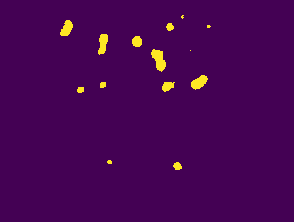

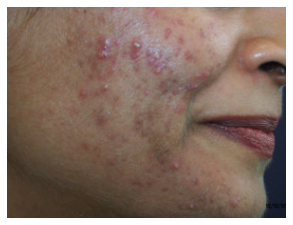

In [7]:
from fastai.vision.image import open_image
Test_mask= open_mask(get_y_fn(Test_fnames[0]))
img=open_image(Test_fnames[0])
img.show(figsize=(5,5))
Test_mask

In [ ]:
np.unique(mask)

array([ImageSegment (1, 222, 294)], dtype=object)

In [ ]:
bs,size = 8,src_size

src= (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=classes)
      )


data= (src.transform(get_transforms(max_rotate = 2.0, max_warp = 0.1), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

name2id = {v:k for k,v in enumerate(classes)}

def accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
name2id

{'Acne': 1, 'Normal': 0}

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=accuracy, wd=1e-2, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
lrs = learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


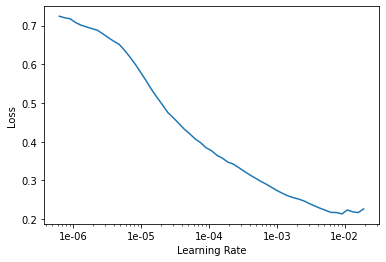

In [ ]:
learn.recorder.plot()

In [ ]:
lr_2=1e-5

In [ ]:
learn.fit_one_cycle(10, slice(lr_2), pct_start=0.6)

epoch,train_loss,valid_loss,accuracy,time
0,0.634622,0.513745,0.806973,01:21
1,0.416230,0.114780,0.982646,00:13
2,0.240473,0.071193,0.990755,00:13
3,0.157262,0.055804,0.991686,00:13
4,0.110647,0.048574,0.992779,00:13
5,0.082852,0.042748,0.993373,00:13
6,0.065550,0.039067,0.993545,00:14
7,0.054463,0.036902,0.993573,00:13
8,0.046750,0.036211,0.993579,00:13
9,0.042936,0.036383,0.993582,00:13


In [ ]:
learn.fit(epochs = 20, lr = slice(None, 2e-4, None), wd = 0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.048737,0.032265,0.993625,00:13
1,0.036292,0.024764,0.993653,00:13
2,0.031438,0.025986,0.993668,00:13
3,0.029293,0.026572,0.993680,00:13
4,0.028644,0.038505,0.993627,00:13
5,0.027663,0.022218,0.993776,00:13
6,0.027012,0.022081,0.993707,00:13
7,0.025478,0.021103,0.993849,00:13
8,0.024375,0.020315,0.993929,00:13
9,0.023719,0.018851,0.993997,00:13


In [ ]:
learn.fit(epochs = 20, lr = slice(None, 2e-4, None), wd = 0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.018339,0.015563,0.994420,00:13
1,0.017532,0.014674,0.994682,00:13
2,0.017552,0.017801,0.994191,00:13
3,0.017701,0.014549,0.994659,00:13
4,0.017905,0.016954,0.994549,00:13
5,0.017768,0.014535,0.994653,00:13
6,0.016992,0.013310,0.994848,00:13
7,0.016248,0.013090,0.995052,00:13
8,0.015561,0.012552,0.995038,00:13
9,0.015346,0.012939,0.995125,00:13


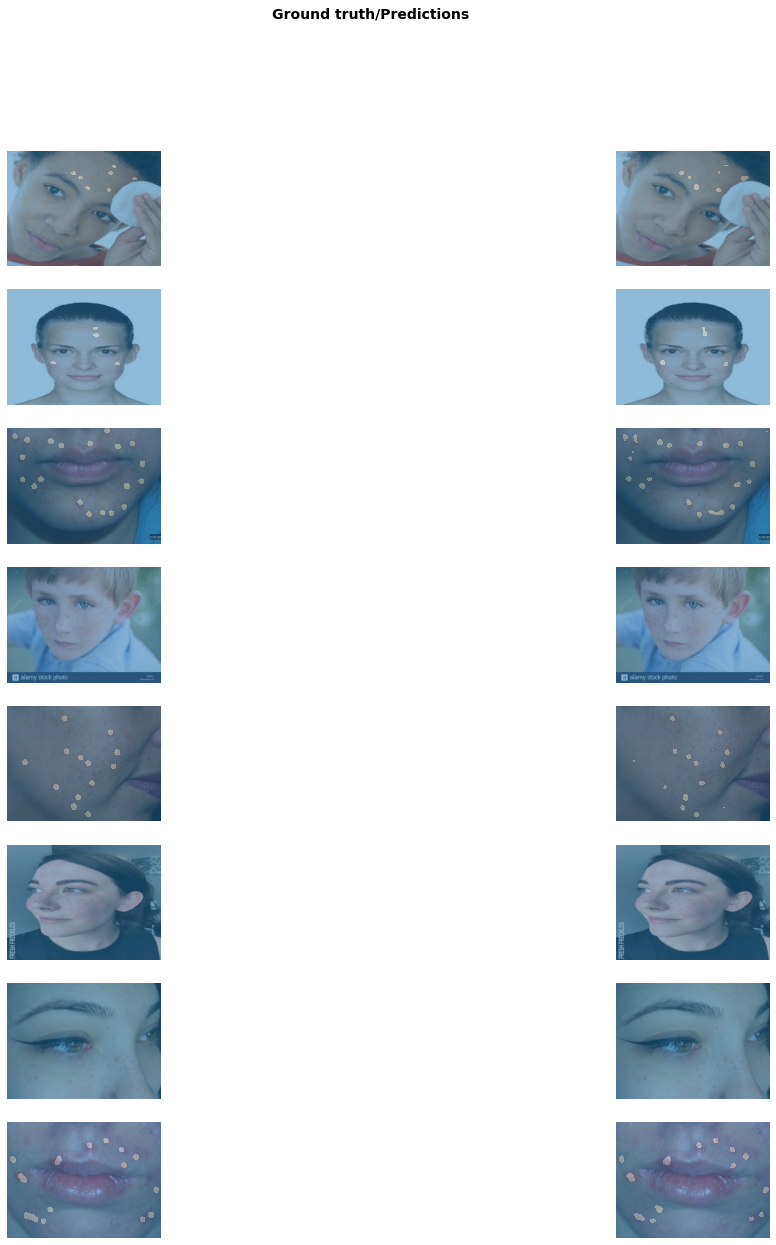

In [ ]:
learn.show_results(rows=9, figsize=(20, 20))

torch.Size([3, 220, 293])


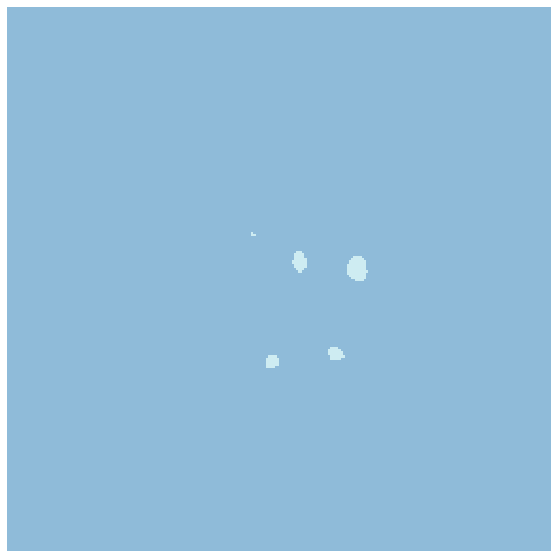

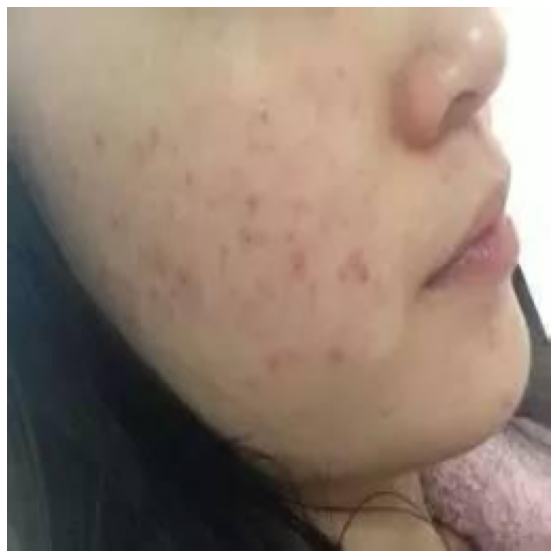

In [ ]:
from fastai.vision.data import resize_to
from PIL import Image

#RANDOM ANOTHER IMAGE(NOT TRAIN IMG)
file = './drive/MyDrive/ACNEDETEC/test/levle1_19.jpg'
img = open_image(file)
img.resize(torch.Size([img.shape[0],256,256]))
print(img.shape)
pred= learn.predict(img)

pred[0].show(figsize=(10,10))
img.show(figsize=(10,10))

tensor(0.0675)


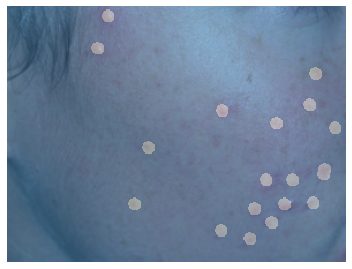

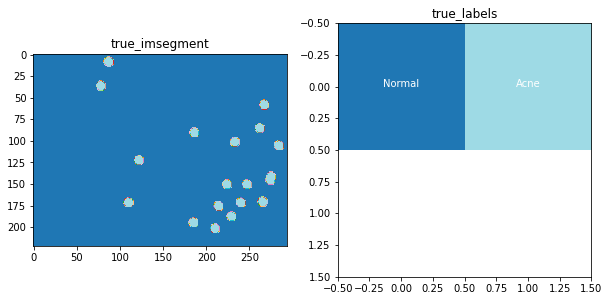

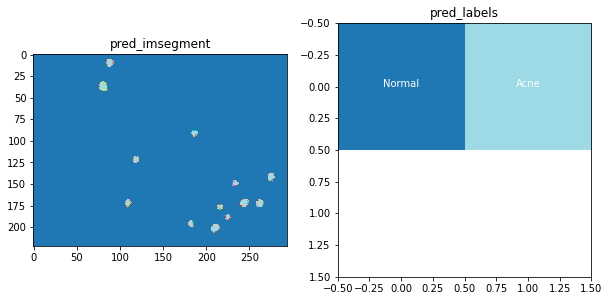

In [ ]:
from fastai.basic_data import DatasetType
from fastai.vision.interpret import SegmentationInterpretation
pred,y,loss=learn.get_preds(with_loss=True)
interp=SegmentationInterpretation.from_learner(learn)
top_losses, top_idxs=interp.top_losses((222,294))
top_losses, top_idxs
print(top_losses[1])
interp.show_xyz(top_idxs[1], classes, sz=10)

label,score
Normal,0.998372
Acne,0.602832


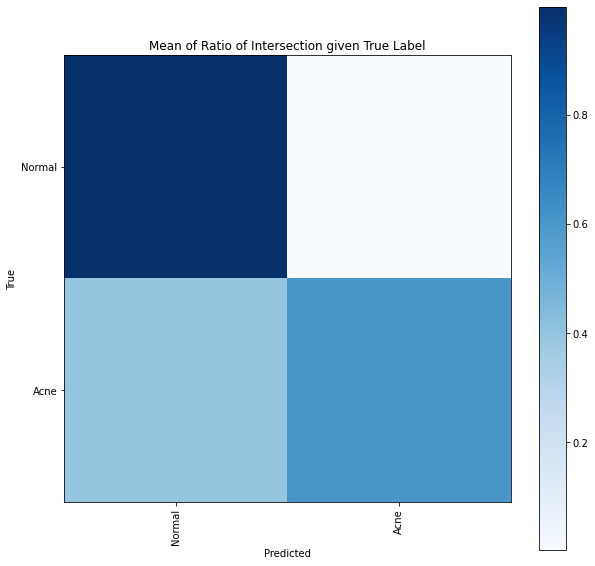

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()
mean_cm.shape, single_img_cm.shape
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# In[36]:


## load the weights into a previously defined model (contained inside learn)
learn.save('model1_trained_5_19_2022')

# In[27]:

## Export the model. The difference here is, that all the required information for retrieval of 
## model is stored in the same file, whereas above methode only stores the weights.
learn.export()